In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
session = tf.Session(config=config)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# load data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False, reshape=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
xs, ys = mnist.train.next_batch(32)

In [5]:
def model_inputs(real_dim=(28, 28, 1), z_dim=(100)):
    with tf.variable_scope('Inputs', reuse=tf.AUTO_REUSE):
        # inputs_real shape is (28, 28, 1) for mnist
        inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
        # inputs_z shape is (100,) for a random noise
        inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
        
    return inputs_real, inputs_z

In [6]:
def Generator(z,alpha=0.2, training=True):
    '''
    生成器
    Args
        z, 输入，是随机噪声
        output_dim, 最后输出的通道数
        alpha, leakyrelu的参数
        trainning, 是否训练阶段，用于batch norm
    '''
    with tf.variable_scope('Generator', reuse=tf.AUTO_REUSE):
        with tf.variable_scope('Reshape'):
            x1 = tf.layers.dense(z, 7*7*512)
            x1 = tf.reshape(x1, (-1, 7, 7, 512))
            x1 = tf.layers.batch_normalization(x1, training=training)
            x1 = tf.nn.leaky_relu(x1, alpha)
            # 7x7x512 now
            
        with tf.variable_scope('ConvT_1'):
            x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
            x2 = tf.layers.batch_normalization(x2, training=training)
            x2 = tf.nn.leaky_relu(x2, alpha)
            # 14x14x256 now
            
        with tf.variable_scope('Outputs'):
            logits = tf.layers.conv2d_transpose(x2, 1, 5, strides=2, padding='same')
            out = tf.tanh(logits)
            # # 28x28x1 now
    return logits, out

In [7]:
def Discriminator(x, alpha=0.2):
    '''
    判别器
    Args
        x, 输入图像，大小为(28, 28, 1)
        alpha, leakyrelu的参数
    '''
    
    with tf.variable_scope('Discriminator', reuse=tf.AUTO_REUSE):
        # input is 28x28x1
        with tf.variable_scope('Conv_1'):
            x1 = tf.layers.conv2d(x, 32, 5, strides=2, padding='same')
            x1 = tf.nn.leaky_relu(x1, alpha)
        with tf.variable_scope('Conv_2'):
            x2 = tf.layers.conv2d(x1, 64, 5, strides=2, padding='same')
            x2 = tf.nn.leaky_relu(x2, alpha)
        with tf.variable_scope('Conv_3'):
            x3 = tf.layers.conv2d(x2, 128, 5, strides=2, padding='same')
            x3 = tf.nn.leaky_relu(x3, alpha)            
        with tf.name_scope('Flatten'):
            flat = tf.reshape(x3, (-1,4*4*128))
        
        with tf.variable_scope('Outputs'):
            logits = tf.layers.dense(flat, 1)
            out = tf.sigmoid(logits)
        
    return logits, out

In [8]:
def model_loss(input_real, input_z, alpha=0.2):
    g_logits, g_out = Generator(inputs_z,training=True)
    
    with tf.variable_scope('Mix_input'):
        real_batch_size = tf.shape(input_real)[0]
        fake_batch_size = tf.shape(input_z)[0]
        d_mix_inputs = tf.concat([inputs_real, g_out], axis=0)
        d_mix_labels = tf.concat([tf.ones([real_batch_size,1]), tf.zeros([fake_batch_size,1])], axis=0)
        # shuffle inputs and labels, seed must be the same
        d_mix_inputs = tf.random_shuffle(d_mix_inputs, seed=1)
        d_mix_labels = tf.random_shuffle(d_mix_labels, seed=1)
        
    d_logits_mix, d_out_mix = Discriminator(d_mix_inputs)
    d_logits_fake, d_out_fake = Discriminator(g_out)
    
    with tf.variable_scope('Loss'):
        with tf.variable_scope('D_loss'):
            d_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(d_mix_labels, d_logits_mix))
        with tf.variable_scope('G_loss'):
            g_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(tf.ones_like(d_logits_fake), d_logits_fake))
            
    return g_loss, d_loss

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'Discriminator')
    g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'Generator')
    # Optimize
    with tf.name_scope('Train'):
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
            g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_train_opt, g_train_opt

In [10]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    #print(samples[epoch].shape)
    for ax, img in zip(axes.flatten(), samples[epoch][0]):
        ax.axis('off')
        #img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img[:,:,0], aspect='equal', cmap='Greys_r')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

Iteration 100/2000... Discirminator loss: 0.5328 Generator loss: 0.8965
Iteration 200/2000... Discirminator loss: 0.3610 Generator loss: 0.9677
Iteration 300/2000... Discirminator loss: 0.3772 Generator loss: 1.4918
Iteration 400/2000... Discirminator loss: 0.3373 Generator loss: 1.0286
Iteration 500/2000... Discirminator loss: 0.2746 Generator loss: 1.5154
Iteration 600/2000... Discirminator loss: 0.3051 Generator loss: 1.1863
Iteration 700/2000... Discirminator loss: 0.2171 Generator loss: 2.1462
Iteration 800/2000... Discirminator loss: 0.2256 Generator loss: 1.5629
Iteration 900/2000... Discirminator loss: 0.2426 Generator loss: 2.4295
Iteration 1000/2000... Discirminator loss: 0.2986 Generator loss: 1.0678


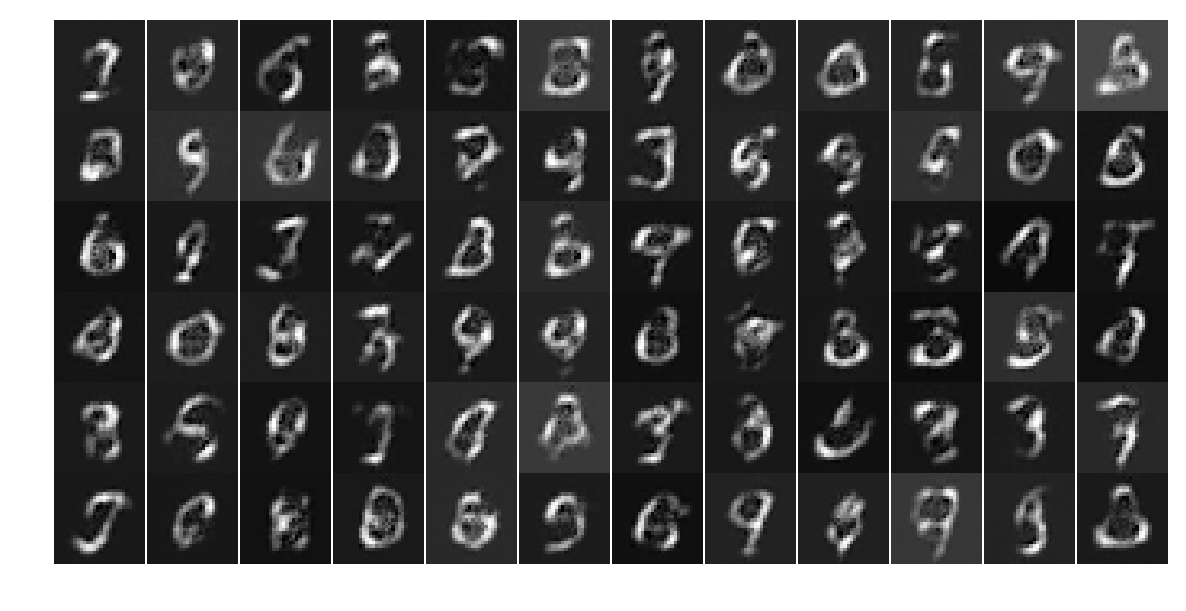

Iteration 1100/2000... Discirminator loss: 0.2998 Generator loss: 1.1107
Iteration 1200/2000... Discirminator loss: 0.2612 Generator loss: 2.6749
Iteration 1300/2000... Discirminator loss: 0.2561 Generator loss: 2.4146
Iteration 1400/2000... Discirminator loss: 0.1907 Generator loss: 1.7602
Iteration 1500/2000... Discirminator loss: 0.2025 Generator loss: 2.3702
Iteration 1600/2000... Discirminator loss: 0.2422 Generator loss: 1.2206
Iteration 1700/2000... Discirminator loss: 0.1353 Generator loss: 2.5612
Iteration 1800/2000... Discirminator loss: 0.1502 Generator loss: 2.1491
Iteration 1900/2000... Discirminator loss: 0.2457 Generator loss: 1.4017
Iteration 2000/2000... Discirminator loss: 0.2406 Generator loss: 2.2871


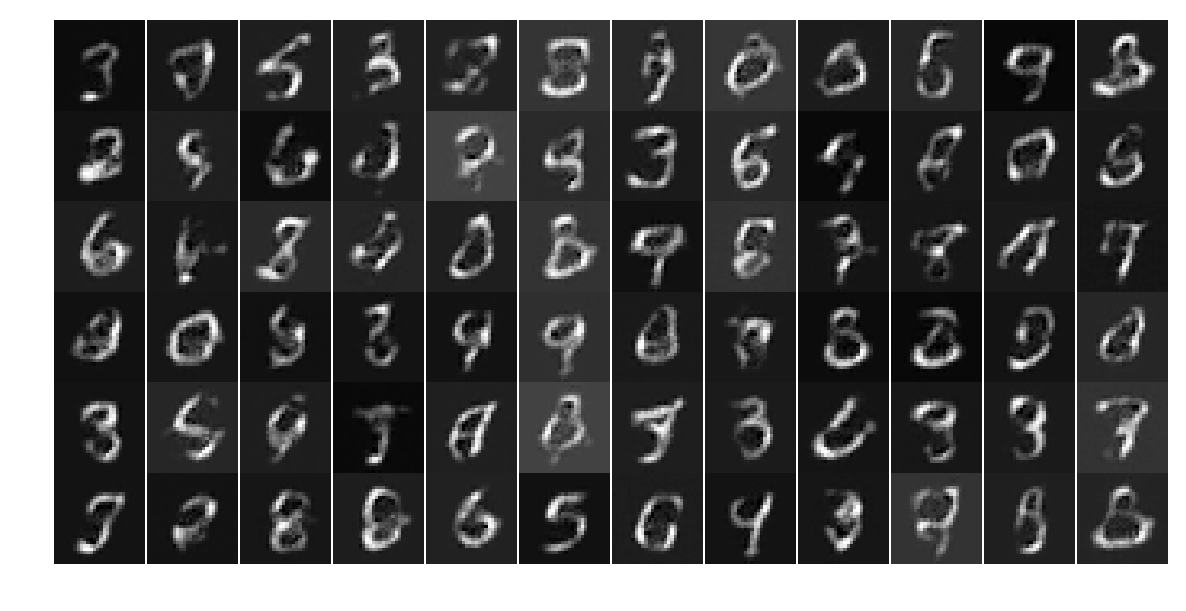

In [11]:
# tensorboard test
batch_size = 50
learning_rate = 0.0002
beta1 = 0.5
z_size = 100
iteration = 2000
every_print = 100


inputs_real, inputs_z = model_inputs((28,28,1), 100)
g_loss, d_loss = model_loss(inputs_real, inputs_z)
d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

#tf.summary.scalar('g_lss', g_loss)
#tf.summary.scalar('d_lss', d_loss)


# train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    samples, losses = [], []
    steps = 0
    
    logs_writer = tf.summary.FileWriter('./logs', sess.graph)
    merge_op = tf.summary.merge_all()
    
    for ii in range(1, iteration+1):
        xs, _ = mnist.train.next_batch(batch_size)
        
        # sample random noise for G
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        
        # run optimizer
        _,= sess.run([g_train_opt], feed_dict={inputs_z:batch_z})
        _,= sess.run([g_train_opt], feed_dict={inputs_z:batch_z})
        #logs_writer.add_summary(results, ii)
        
        _, = sess.run([d_train_opt], feed_dict={inputs_real:xs, inputs_z:batch_z})
#         logs_writer.add_summary(results, ii)
        
        
        # print loss
        if ii % every_print == 0:
            train_d_loss = sess.run(d_loss, feed_dict={inputs_real:xs, inputs_z:batch_z})
            train_g_loss = sess.run(g_loss, feed_dict={inputs_z:batch_z})
            print('Iteration {}/{}...'.format(ii, iteration),
                  'Discirminator loss: {:.4f}'.format(train_d_loss),
                  'Generator loss: {:.4f}'.format(train_g_loss))
            
            losses.append([train_d_loss, train_g_loss])
            
        # plot samples
        if ii % 1000 == 0:
            
            gen_samples = sess.run(Generator(inputs_z, training=False), feed_dict={inputs_z:sample_z})
            samples.append(gen_samples)
            
            _ = view_samples(-1, samples, 6, 12, figsize=(10, 5))
            plt.show()
    

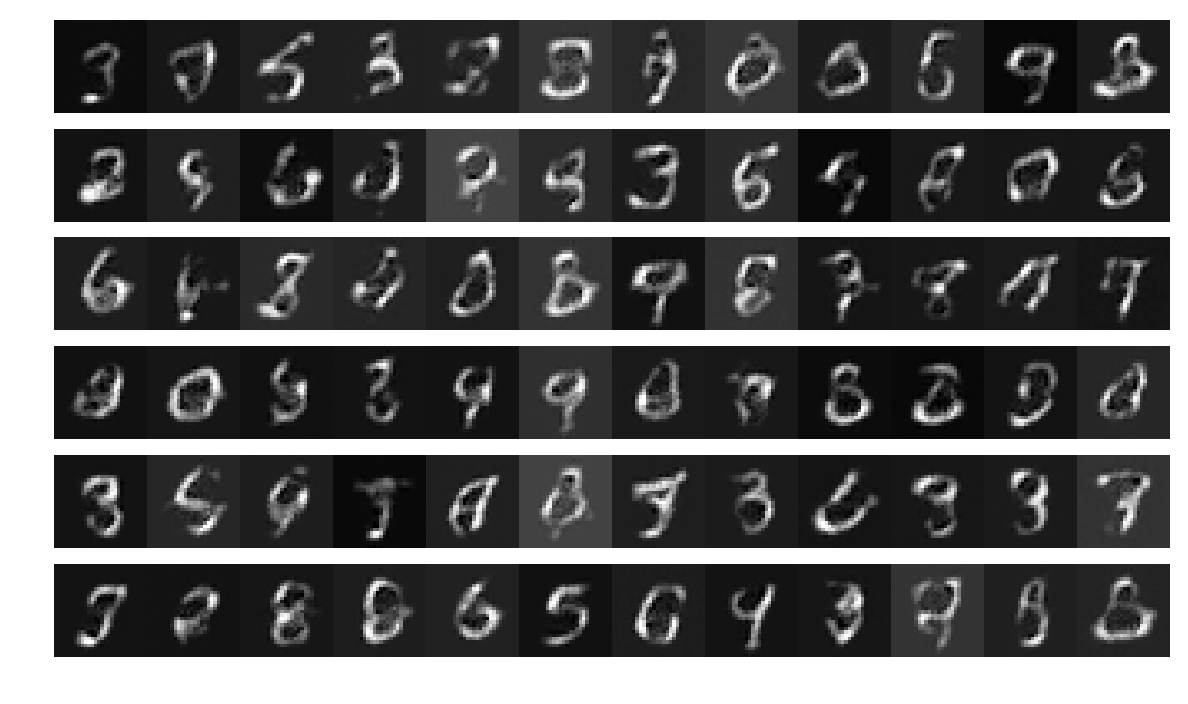

In [12]:
_ = view_samples(-1, samples, 6, 12, figsize=(10, 6))
plt.show()

## 总结

大体生成了一些看上去还不错的数据
代码中，每训练一次D,就训练两次G，因为D的任务比较容易，学习的较快，因此让G多学习，好追赶上D